In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/german-credit-data-with-risk/german_credit_data.csv


In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import balanced_accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

# Knowing Dataset

This dataset provides insights into loan applications and borrower characteristics. It includes information on demographic details like age and gender, occupational information captured through a job category (ranging from unskilled non-residents to highly skilled workers), housing situation (owned, rented, or free), and financial standing as reflected by savings accounts (categorized as little, moderate, quite rich, or rich), checking account balance, and credit amount (all in Deutsch Mark). Additionally, the dataset details the duration (in months) of the loan application and the purpose for which the loan is sought (car, furniture, appliances, etc.). This rich set of features allows for analysis of factors that may influence loan application behavior and creditworthiness.

* Age (numeric)
* Sex (text: male, female)
* Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
* Housing (text: own, rent, or free)
* Saving accounts (text - little, moderate, quite rich, rich)
* Checking account (numeric, in DM - Deutsch Mark)
* Credit amount (numeric, in DM)
* Duration (numeric, in month)
* Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [3]:
data = pd.read_csv("/kaggle/input/german-credit-data-with-risk/german_credit_data.csv",index_col=0)
data.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
5,35,male,1,free,NaN,NaN,9055,36,education,good
6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
7,35,male,3,rent,little,moderate,6948,36,car,good
8,61,male,1,own,rich,NaN,3059,12,radio/TV,good
9,28,male,3,own,little,moderate,5234,30,car,bad


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


# Data Explorations

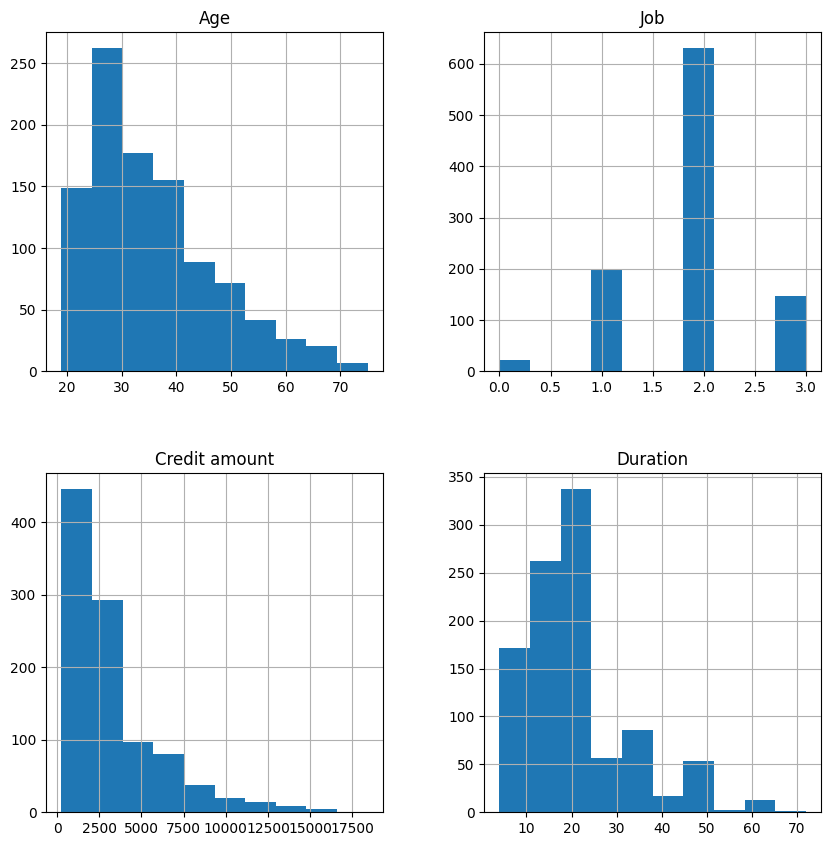

In [5]:
# numerical data explorations
data.hist(figsize=(10,10))
plt.subplots_adjust(bottom=0.1)
plt.show()

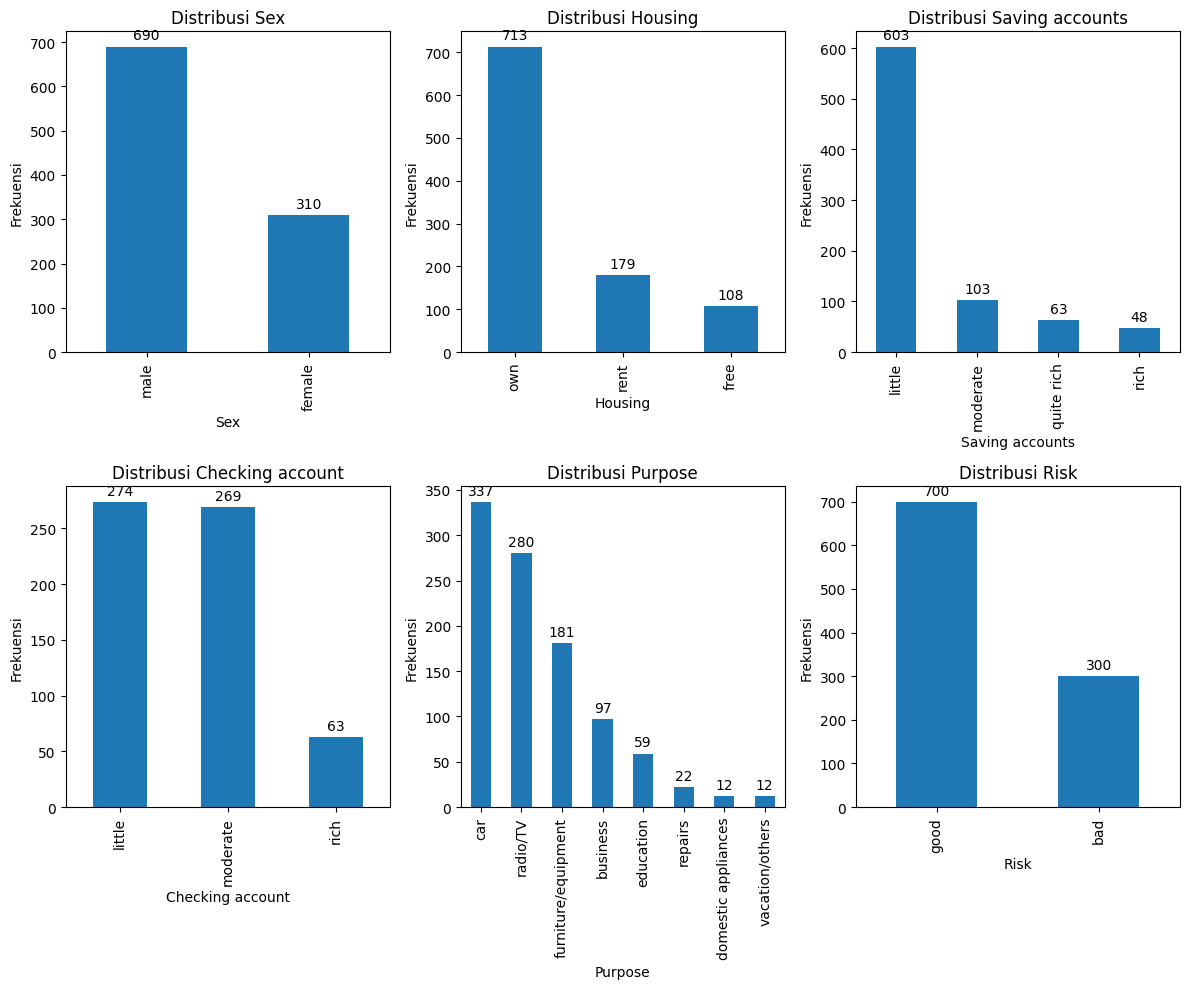

In [6]:
# Categorical data explorations

# Identifying categorical column
categorical_cols = data.select_dtypes(include=['category', 'object']).columns

# Make a 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

# Iterate through each column and plot on the corresponding subplot
for ax, col in zip(axes.flatten(), categorical_cols):
    value_counts = data[col].value_counts()
    bars = value_counts.plot(kind='bar', ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('Frekuensi')
    ax.set_title(f'Distribusi {col}')
    
    # Added a description of the number of class grades in each bar
    for bar in bars.containers[0]:
        height = bar.get_height()
        ax.annotate(f'{int(height)}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Organize layouts
plt.tight_layout()
plt.show()


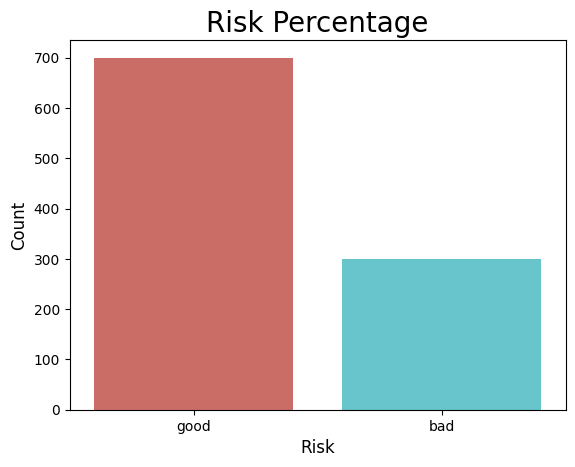

In [7]:
# Distribution of each class for the Target variable

g = sns.countplot(x="Risk", data=data,
              palette="hls")
g.set_xlabel("Risk", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Risk Percentage", fontsize=20)

plt.show()

# Handling Missing Values

In [8]:
df = pd.DataFrame(data)

# Convert a categorical column to numeric
df_encoded = df.copy()
df_encoded['Sex'] = df_encoded['Sex'].map({'male': 0, 'female': 1})
df_encoded['Housing'] = df_encoded['Housing'].map({'own': 0, 'rent': 1, 'free': 2})
df_encoded['Saving accounts'] = df_encoded['Saving accounts'].map({'little': 0, 'moderate': 1, 'quite rich': 2, 'rich': 3})
df_encoded['Checking account'] = df_encoded['Checking account'].map({'little': 0, 'moderate': 1, 'rich': 2})
df_encoded['Purpose'] = df_encoded['Purpose'].map({'car': 0, 'business': 1, 'furniture/equipment': 2, 'radio/TV': 3, 'education': 4, 'domestic appliances':5,'repairs':6, 'vacation/others':7 })
df_encoded['Risk'] = df_encoded['Risk'].map({'good': 0, 'bad': 1})

# Imputing NaN values in 'Saving accounts' using Iterative Imputer
imputer_saving = IterativeImputer(max_iter=10, random_state=0)
df_encoded['Saving accounts'] = imputer_saving.fit_transform(df_encoded[['Age', 'Sex', 'Job', 'Housing', 'Credit amount', 'Duration', 'Purpose', 'Risk', 'Saving accounts']])[:, -1]

# Imputing NaN values in 'Checking accounts' using Iterative Imputer
imputer_checking = IterativeImputer(max_iter=10, random_state=0)
df_encoded['Checking account'] = imputer_checking.fit_transform(df_encoded[['Age', 'Sex', 'Job', 'Housing', 'Credit amount', 'Duration', 'Purpose', 'Risk', 'Checking account']])[:, -1]

# Reverse to real Value
reverse_map_saving = {0: 'little', 1: 'moderate', 2: 'quite rich', 3: 'rich'}
reverse_map_checking = {0: 'little', 1: 'moderate', 2: 'rich'}

df_encoded['Saving accounts'] = df_encoded['Saving accounts'].round().map(reverse_map_saving)
df_encoded['Checking account'] = df_encoded['Checking account'].round().map(reverse_map_checking)

# Result
print(df_encoded)

     Age  Sex  Job  Housing Saving accounts Checking account  Credit amount  \
0     67    0    2        0        moderate           little           1169   
1     22    1    2        0          little         moderate           5951   
2     49    0    1        0          little         moderate           2096   
3     45    0    2        2          little           little           7882   
4     53    0    2        2          little           little           4870   
..   ...  ...  ...      ...             ...              ...            ...   
995   31    1    1        0          little         moderate           1736   
996   40    0    3        0          little           little           3857   
997   38    0    2        0          little         moderate            804   
998   23    0    2        2          little           little           1845   
999   27    0    2        0        moderate         moderate           4576   

     Duration  Purpose  Risk  
0           6       

In [9]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   int64 
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   int64 
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   int64 
 9   Risk              1000 non-null   int64 
dtypes: int64(8), object(2)
memory usage: 85.9+ KB


In [10]:
df_encoded['Saving accounts'] = df_encoded['Saving accounts'].map({'little': 0, 'moderate': 1, 'quite rich': 2, 'rich': 3})
df_encoded['Checking account'] = df_encoded['Checking account'].map({'little': 0, 'moderate': 1, 'rich': 2})

# Data Preprocessing

In [11]:
# Make Feature (X/Dependent Variable) & Target (Y/Independent Variabel)

X = df_encoded.drop('Risk', axis=1) 
y = df_encoded['Risk']


In [12]:
from sklearn.preprocessing import StandardScaler
# Normalize a Feature
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
from sklearn.model_selection import train_test_split

# Make Train-Test Data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Modelling

In [14]:
# Balanced Random Forest Modeling

# Intiate BalancedRandomForestClassifier Model
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=41)  # n_jobs=-1 untuk pemrosesan paralel

# Fitting model
brf.fit(X_train, y_train)

# Predicting y 
y_pred = brf.predict(X_test)

# Count Metric Performance
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Accuracy:  0.69
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       141
           1       0.48      0.59      0.53        59

    accuracy                           0.69       200
   macro avg       0.65      0.66      0.65       200
weighted avg       0.71      0.69      0.70       200

Balanced Accuracy: 0.66185839644188


In [15]:
# Voting Classifier Modeling

seed = 1702

# Intiate Voting Classifier  with LGBM, dart, & Catboost Model
lgb_model = LGBMClassifier(random_state = seed, verbose = -1)
dart_model = LGBMClassifier(random_state = seed, boosting_type = 'dart', verbose = -1)
cb_model = CatBoostClassifier(random_state = seed, verbose = 0)
voting = VotingClassifier(estimators=[
    ('lgb', lgb_model),
    ('dart', dart_model),
    ('cb', cb_model)
], voting='soft')

# Fitting model
voting.fit(X_train,y_train)

# Predicting y 
y_pred = voting.predict(X_test)

# Count Metric Performance
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy:  0.77
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       141
           1       0.70      0.39      0.50        59

    accuracy                           0.77       200
   macro avg       0.74      0.66      0.68       200
weighted avg       0.76      0.77      0.75       200

Balanced Accuracy: 0.6594542613294867
